In [1]:
import gym
from gym import Env, spaces

import numpy as np
import seaborn as sns
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import random
import networkx as nx
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch,HandlerTuple
import matplotlib.patches as patches
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

import gymnasium as gym
from gymnasium import Env, spaces

from sklearn import preprocessing
from matplotlib.patches import FancyArrowPatch

c:\Users\tass\anaconda3\Lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



In [2]:

num_drones = 4
limite_y = 80
limite_x = 100
alcance_comunicacao_jammer = 25
alcance_comunicacao_nos = 5000
B_Hz = 2.4e9
posicoes = np.array([[18, 52], [33, 20], [44, 15], [48, 25]])
posicao_jammer = np.array([40, 70])

In [3]:
# Definir a subgrade dentro da área maior
area_size = (100, 100)
subgrade_start = (25, 20)  # Ponto inicial da subgrade (x, y)
subgrade_size = (50, 40)   # Tamanho da subgrade (largura, altura)
resolution = 5             # Resolução da subgrade (distância entre pontos)

# Gerar os pontos discretizados na subgrade
x_points = np.arange(subgrade_start[0], subgrade_start[0] + subgrade_size[0] + 1, resolution)
y_points = np.arange(subgrade_start[1], subgrade_start[1] + subgrade_size[1] + 1, resolution)
grid_points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1, 2)


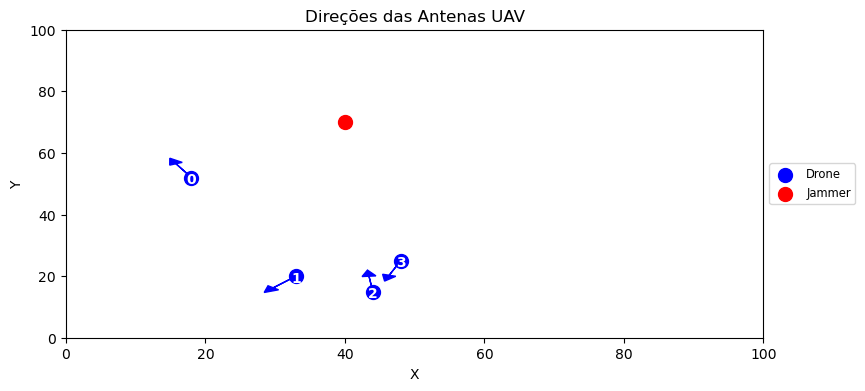

In [4]:
# Função para calcular a distância entre duas posições
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Função para encontrar vizinhos dentro do alcance de comunicação
def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

# Função para verificar quais drones são afetados pelo jammer
def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

# Gera direções aleatórias para as antenas
direcoes_antena = np.random.uniform(0, 360, size=num_drones)
# direcoes_antena = [278, 102, 235, 312, 182, 242]
afetados_pelo_jammer=verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)
# Comprimento das setas para indicar a direção das antenas
comprimento_seta = 5



# Visualização usando Matplotlib
def render_v2(posicoes, direcoes_antena, posicao_jammer, comprimento_seta=5, area_size=(100, 100)):
    afetados_pelo_jammer = verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)

    fig, ax = plt.subplots(figsize=(9, 4))

    # Desenha os drones no gráfico
    for i, pos in enumerate(posicoes):
        ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
        ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

    # Desenha as setas para a direção das antenas
    for i, direcao in enumerate(direcoes_antena):
        direcao_rad = np.radians(direcao)  # Converte para radianos
        dx = comprimento_seta * np.cos(direcao_rad)  # Deslocamento em x
        dy = comprimento_seta * np.sin(direcao_rad)  # Deslocamento em y
        
        ax.arrow(
            posicoes[i][0], posicoes[i][1], 
            dx, dy, 
            head_width=2, head_length=2, fc='b', ec='b'
        )  # Seta azul para indicar a direção da antena

    # Desenha o jammer
    ax.scatter(posicao_jammer[0], posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

    # Configurações finais do gráfico
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, area_size[0])
    ax.set_ylim(0, area_size[1])
    ax.set_yticks(np.arange(0, area_size[1]+1, 20))
    plt.title('Direções das Antenas UAV')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    plt.show()

render_v2(posicoes, direcoes_antena, posicao_jammer, comprimento_seta)


In [5]:
import numpy as np

# Função para calcular o ângulo entre dois nós em relação à direção da antena
def angulo_entre_nos(pos1, direcao_antena, pos2):
    # Vetor entre os dois nós
    delta_x = pos2[0] - pos1[0]
    delta_y = pos2[1] - pos1[1]
    
    # Direção do vetor em graus
    direcao_vetor_rad = np.arctan2(delta_y, delta_x)
    direcao_vetor_deg = np.degrees(direcao_vetor_rad)
    
    # Diferença entre a direção do vetor e a direção da antena
    angulo = direcao_vetor_deg - direcao_antena
    
    # Ajustar para o intervalo de 0 a 360 graus
    angulo = angulo % 360  # Usa módulo para garantir que o valor esteja entre 0 e 360
    angulo_arredondado = round(angulo)
    
    return angulo_arredondado

# Posições dos drones
# posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

# Direções aleatórias das antenas
# direcoes_antena = np.random.uniform(0, 360, size=posicoes.shape[0])

# Matriz para armazenar os ângulos
angulos_matriz = np.zeros((posicoes.shape[0], posicoes.shape[0]))

# Calcular os ângulos para todas as combinações de drones
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            angulos_matriz[i, j] = angulo_entre_nos(posicoes[i], direcoes_antena[i], posicoes[j])

# Apresentar os ângulos entre drones sem valores negativos
for i in range(posicoes.shape[0]):
    print(f"Drones que o drone {i} 'vê' com um ângulo:")
    for j in range(posicoes.shape[0]):
        if i != j:
            angulo_arredondado = int(round(angulos_matriz[i, j]))  # Arredondar para unidade
            print(f"  Com o drone {j}: {angulo_arredondado} graus")

Drones que o drone 0 'vê' com um ângulo:
  Com o drone 1: 179 graus
  Com o drone 2: 189 graus
  Com o drone 3: 202 graus
Drones que o drone 1 'vê' com um ângulo:
  Com o drone 0: 246 graus
  Com o drone 2: 106 graus
  Com o drone 3: 149 graus
Drones que o drone 2 'vê' com um ângulo:
  Com o drone 0: 29 graus
  Com o drone 1: 59 graus
  Com o drone 3: 332 graus
Drones que o drone 3 'vê' com um ângulo:
  Com o drone 0: 247 graus
  Com o drone 1: 308 graus
  Com o drone 2: 357 graus


In [ ]:
Ptx_dBm = 20 
f = 2.4e9 
B_Hz= 2.4e9
d0=1
gamma=2
sigma = 0
c=3e8
lambda_m=c/f
L0=30
potencia_jammer_dBm =100

# Ler o arquivo de ganhos para criar uma tabela de busca
ganhos_df = pd.read_csv('ganhos.csv')

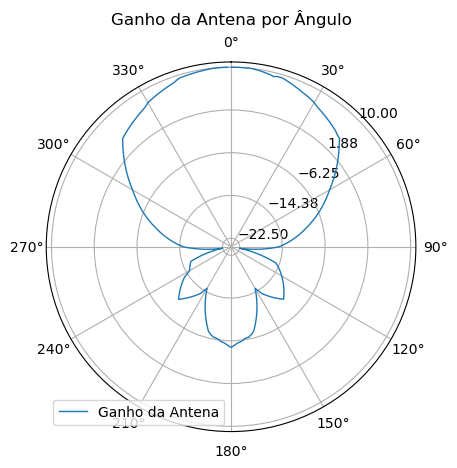

In [7]:
angulos = np.deg2rad(ganhos_df['angulo'])  # Converter graus para radianos
ganhos = ganhos_df['ganho']

# Criar um gráfico polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angulos, ganhos, linestyle='-', linewidth=1, label='Ganho da Antena')

# Ajustar o layout
ax.set_theta_zero_location('N')  # Configurar a direção Norte como o topo do gráfico
ax.set_theta_direction(-1)  # Configurar a direção dos ângulos para sentido horário
ax.set_rmax(max(ganhos) + 1)  # Ajustar o raio máximo para melhor visualização
ax.set_rticks(np.linspace(min(ganhos), max(ganhos), num=5))  # Definir os ticks para o raio
ax.set_rlabel_position(45)  # Posicionar os labels do raio

# Configurar os ticks para o ângulo
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Definir marcas de ângulo a cada 30 graus

# Adicionar legenda e título
ax.legend()
ax.set_title('Ganho da Antena por Ângulo', va='bottom')

# Mostrar o gráfico
plt.show()

In [8]:
def busca_ganhos( angulo):
    # Arredondar para o ângulo inteiro mais próximo
    angulo_ajustado = int(round(angulo))
    
    if angulo_ajustado==360:
        angulo_ajustado=0
    
    # Encontrar o ganho correspondente ao ângulo ajustado
    # ganho = ganhos_df.loc[ganhos_df['angulo'] == angulo_ajustado, 'ganho'].iloc[0]
    ganho=0
    
    return ganho



# Função para calcular os ganhos de transmissão e recepção
def calcula_ganhos(posicoes, direcoes_antena, indice_transmissor, indice_receptor, ganhos_df):
    # Verificar se o índice está dentro do limite de direcoes_antena
    if indice_transmissor >= len(direcoes_antena) or indice_receptor >= len(direcoes_antena):
        print(f"Erro: índice fora dos limites de direcoes_antena. Transmissor: {indice_transmissor}, Receptor: {indice_receptor}, Tamanho de direcoes_antena: {len(direcoes_antena)}")
        return 0, 0  # Retorne ganhos padrão ou levante um erro

    # Obter posições e direções
    pos1 = posicoes[indice_transmissor]
    pos2 = posicoes[indice_receptor]
    direcao_antena1 = direcoes_antena[indice_transmissor]
    direcao_antena2 = direcoes_antena[indice_receptor]

    # Calcular o ângulo entre os dois nós em relação à direção da antena
    angulo_transmissao = angulo_entre_nos(pos1, direcao_antena1, pos2)
    angulo_rececao = angulo_entre_nos(pos2, direcao_antena2, pos1)

    # Obter os ganhos para transmissão e recepção
    ganho_transmissao = busca_ganhos(angulo_transmissao)
    ganho_rececao = busca_ganhos(angulo_rececao)
    
    return ganho_transmissao, ganho_rececao

# ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, 0, 1, ganhos_df)



def calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d,f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    # L = (4 * np.pi * d / lambda_m)**2
    # Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - 10 * np.log10(L)
    # return Prx_dBm
    # Calcular a perda de percurso
    if d > 0:
        L = L0 + 10 * gamma * np.log10(d / d0) + np.random.normal(0, sigma)
    else:
        L = L0  # Se a distância for zero, assume-se a perda na distância de referência

    # Calcular a potência do sinal recebido
    Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - L

    return Prx_dBm

def calcula_potencia_jammer(pos_drone, direcao_antena_drone, pos_jammer, potencia_jammer_dBm, ganhos_df):
    # Calcular a distância entre o drone e o jammer
    d = distancia(pos_drone, pos_jammer)
    
    # Calcular o ângulo entre o drone e o jammer
    angulo_entre_drone_e_jammer = angulo_entre_nos(pos_drone, direcao_antena_drone, pos_jammer)
    
    # Obter o ganho do drone em direção ao jammer
    ganho_drone_para_jammer = busca_ganhos( angulo_entre_drone_e_jammer)
    
    # Calcular a potência do ruído recebido usando a equação de Friis
    L = (4 * np.pi * d / lambda_m) ** 2  # Perda de propagação
    potencia_jammer_recebida_dBm = potencia_jammer_dBm + ganho_drone_para_jammer - 10 * np.log10(L)
    
    return potencia_jammer_recebida_dBm

def calcula_capacidade(potencia_sinal_dBm, potencia_ruido_dBm):
    """
    Calcula a capacidade do canal em bits por segundo usando a fórmula de Shannon-Hartley.
    """
    # Converter potência em dBm para Watts
    potencia_sinal_W = 10 ** (potencia_sinal_dBm / 10) / 1000  # Potência do sinal em Watts
    potencia_ruido_W = 10 ** (potencia_ruido_dBm / 10) / 1000  # Potência do ruído em Watts
    
    # Calcular a razão sinal-ruído (SNR)
    snr = potencia_sinal_W / potencia_ruido_W
    
    # Calcular a capacidade do canal em bits por segundo (bps)
    capacidade = B_Hz * np.log2(1 + snr)
    
    return capacidade/1e3

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            # Calcular a distância entre os dois drones
            d = distancia(posicoes[i], posicoes[j])
            
            # Calcular os ganhos de transmissão e recepção
            ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, i, j, ganhos_df)
            # print(posicoes)
            print('Ganhos Rx,Tx:',ganho_transmissao, ganho_rececao)
            # Calcular a potência do sinal recebido usando a equação de Friis
            potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
            potencia_ruido = calcula_potencia_jammer(posicoes[j], direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
            capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
            # Imprimir a combinação de nós e a potência do sinal recebido
            print(f"  Potencia recebida do drone {i} para o drone {j}: {potencia_recebida:.2f} dBm")
            print(f"  Ruido recebido no drone {j} e do jammer: {potencia_ruido:.2f} dBm")
            print(f"  Capacidade do canal {i} para {j}: {capacidade_canal:.2f} bps")



Ganhos Rx,Tx: 0 0
  Potencia recebida do drone 0 para o drone 1: -40.97 dBm
  Ruido recebido no drone 1 e do jammer: 25.89 dBm
  Capacidade do canal 0 para 1: 0.71 bps
Ganhos Rx,Tx: 0 0
  Potencia recebida do drone 0 para o drone 2: -43.11 dBm
  Ruido recebido no drone 2 e do jammer: 25.12 dBm
  Capacidade do canal 0 para 2: 0.52 bps
Ganhos Rx,Tx: 0 0
  Potencia recebida do drone 0 para o drone 3: -42.12 dBm
  Ruido recebido no drone 3 e do jammer: 26.75 dBm
  Capacidade do canal 0 para 3: 0.45 bps
Ganhos Rx,Tx: 0 0
  Potencia recebida do drone 1 para o drone 0: -40.97 dBm
  Ruido recebido no drone 0 e do jammer: 30.88 dBm
  Capacidade do canal 1 para 0: 0.23 bps
Ganhos Rx,Tx: 0 0
  Potencia recebida do drone 1 para o drone 2: -31.64 dBm
  Ruido recebido no drone 2 e do jammer: 25.12 dBm
  Capacidade do canal 1 para 2: 7.29 bps
Ganhos Rx,Tx: 0 0
  Potencia recebida do drone 1 para o drone 3: -33.98 dBm
  Ruido recebido no drone 3 e do jammer: 26.75 dBm
  Capacidade do canal 1 para 3: 2

In [44]:
seed=0

class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 90)):
        super().__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes.copy()
        self.posicao_jammer = posicao_jammer
        self.ultimo_info = {}

        # Define o espaço de ação: direções das antenas + deslocamentos x e y
        self.action_space = spaces.Box(low=np.array([0]*num_uavs + [-40]*num_uavs + [-40]*num_uavs), 
                                       high=np.array([360]*num_uavs + [40]*num_uavs + [40]*num_uavs), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=360, shape=(num_uavs,), dtype=np.float32)

        self.direcoes_antena = np.random.uniform(0, 360, size=num_uavs)
        self.capacidades = []  # Inicializa a lista de capacidades para normalização
        self.subgrade_size=subgrade_size
        self.subgrade_start=subgrade_start
        self.ganhos_df=ganhos_df

    def step(self, action):
        direcoes_antena = action[:self.num_uavs]
        movimentos_x = action[self.num_uavs:2*self.num_uavs]
        movimentos_y = action[2*self.num_uavs:]

        self.direcoes_antena = np.array(direcoes_antena)
        
        for i in range(self.num_uavs):
            nova_pos_x = self.posicoes[i][0] + movimentos_x[i]
            nova_pos_y = self.posicoes[i][1] + movimentos_y[i]
            nova_pos_x = min(max(nova_pos_x, subgrade_start[0]), subgrade_start[0] + subgrade_size[0])
            nova_pos_y = min(max(nova_pos_y, subgrade_start[1]), subgrade_start[1] + subgrade_size[1])
            self.posicoes[i] = np.array([nova_pos_x, nova_pos_y])

        capacidades_por_link = []

        for i in range(self.posicoes.shape[0]):
            for j in range(self.posicoes.shape[0]):
                if i != j:
                    d = distancia(self.posicoes[i], self.posicoes[j])
                    ganho_transmissao, ganho_rececao = calcula_ganhos(self.posicoes, self.direcoes_antena, i, j, ganhos_df)
                    potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
                    potencia_ruido = calcula_potencia_jammer(self.posicoes[j], self.direcoes_antena[j], self.posicao_jammer, potencia_jammer_dBm, ganhos_df)
                    capacidade_canal = calcula_capacidade(potencia_recebida, potencia_ruido)
                    capacidades_por_link.append(capacidade_canal)

        capacidade_media = np.mean(capacidades_por_link)
        capacidade_minima = np.min(capacidades_por_link)

        self.capacidades.extend(capacidades_por_link)
        if len(self.capacidades) > 1000:
            self.capacidades = self.capacidades[-1000:]

        min_capacidade = np.min(self.capacidades)
        max_capacidade = np.max(self.capacidades)
        # capacidade_media_normalizada = (capacidade_media - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)
        # capacidade_minima_normalizada = (capacidade_minima - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)

        G = nx.Graph()
        num_drones = self.posicoes.shape[0]
        capacidade_matriz = np.zeros((self.num_uavs, self.num_uavs))
        link_index = 0

        for i in range(self.num_uavs):
            for j in range(self.num_uavs):
                if i != j:
                    capacidade_matriz[i, j] = capacidades_por_link[link_index]
                    link_index += 1

        for i in range(num_drones):
            for j in range(i + 1, num_drones):
                capacidade = capacidade_matriz[i, j]
                G.add_edge(i, j, weight=1.0 / capacidade)

        bottlenecks = {}
        for i in range(num_drones):
            for j in range(num_drones):
                if i != j:
                    try:
                        caminho = nx.dijkstra_path(G, source=i, target=j, weight='weight')
                        menor_capacidade = float('inf')
                        for k in range(len(caminho) - 1):
                            cap_atual = capacidade_matriz[caminho[k], caminho[k+1]]
                            if cap_atual < menor_capacidade:
                                menor_capacidade = cap_atual
                        bottlenecks[(i, j)] = (caminho, menor_capacidade)
                    except nx.NetworkXNoPath:
                        print(f"Não há caminho do nó {i} para o nó {j}")

        capacidade_bottleneck_media = np.mean([bottleneck for caminho, bottleneck in bottlenecks.values()])
        capacidade_bottleneck_minima = np.min([bottleneck for caminho, bottleneck in bottlenecks.values()])

        # capacidade_bottleneck_media_normalizada = (capacidade_bottleneck_media - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)
        # capacidade_bottleneck_minima_normalizada = (capacidade_bottleneck_minima - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)

        distancia_jammer = np.mean([distancia(pos, self.posicao_jammer) for pos in self.posicoes])
        penalidade_distancia_jammer = -(distancia_jammer ** 2)  # Ajustado para escala apropriada

        distancias_entre_drones = [distancia(self.posicoes[i], self.posicoes[j]) for i in range(num_drones) for j in range(i+1, num_drones)]
        distancia_minima_entre_drones = np.min(distancias_entre_drones)
        penalidade_proximidade_drones = (max(0, (30 - distancia_minima_entre_drones) ** 2))  # Ajustado para escala apropriada

        # Ajuste da função de recompensa para refletir as penalidades não normalizadas
        recompensa = capacidade_media * capacidade_bottleneck_minima - ( 0 * penalidade_distancia_jammer + 0 * penalidade_proximidade_drones)

        capacidades_por_link = [round(capacidade, 3) for capacidade in capacidades_por_link]
        capacidade_media = round(capacidade_media, 3)

        info = {
            'Recompensa': recompensa,
            'Capacidade média [Kbps]': capacidade_media,
            'Capacidades_por_link [Kbps]': capacidades_por_link,
            'Matriz de Capacidades [Kbps]': capacidade_matriz,
            'Capacidade mínima [Kbps]': capacidade_minima,
            # 'Capacidade média normalizada': capacidade_media_normalizada,
            # 'Capacidade mínima normalizada': capacidade_minima_normalizada,
            'Capacidade bottleneck média': capacidade_bottleneck_media,
            'Capacidade bottleneck mínima': capacidade_bottleneck_minima,
            # 'Capacidade bottleneck média normalizada': capacidade_bottleneck_media_normalizada,
            # 'Capacidade bottleneck mínima normalizada': capacidade_bottleneck_minima_normalizada,
            'Penalidade distância ao jammer': penalidade_distancia_jammer,
            'Penalidade proximidade entre drones': penalidade_proximidade_drones
        }

        done = False
        return np.array(self.direcoes_antena), recompensa, done, info

    def render(self, mode='human'):
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(8, 6))

        subgrade_start = self.subgrade_start
        subgrade_size = self.subgrade_size
        resolution = 5

        # Desenhar subgrade com cores mais intensas e linhas finas
        rect = plt.Rectangle(subgrade_start, subgrade_size[0], subgrade_size[1], linewidth=1.5, edgecolor='dodgerblue', facecolor='none')
        ax.add_patch(rect)

        for x in np.arange(subgrade_start[0], subgrade_start[0] + subgrade_size[0] + resolution, resolution):
            ax.axvline(x, color='dodgerblue', linestyle='--', linewidth=0.7, alpha=0.8)
        for y in np.arange(subgrade_start[1], subgrade_start[1] + subgrade_size[1] + resolution, resolution):
            ax.axhline(y, color='dodgerblue', linestyle='--', linewidth=0.7, alpha=0.8)

        # Desenhar os drones com cores distintas
        for i, pos in enumerate(self.posicoes):
            ax.scatter(pos[0], pos[1], color='dimgray', s=200, edgecolor='white', linewidth=1, label='UAV' if i == 0 else "")
            ax.text(
                pos[0], pos[1] + 0.1,  # Ajuste 0.5 para centralizar o texto verticalmente
                f'{i}', 
                horizontalalignment='center', 
                verticalalignment='center', 
                color='white', fontweight='bold'
            )

        # Desenhar setas para indicar a direção de cada drone
        # arrow_length = 3  # Comprimento da seta
        # for i, (x, y) in enumerate(self.posicoes):
        #     direcao = np.deg2rad(self.direcoes_antena[i])  # Converte para radianos
        #     dx = arrow_length * np.cos(direcao)  # Comprimento da seta no eixo X
        #     dy = arrow_length * np.sin(direcao)  # Comprimento da seta no eixo Y
        #     ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='dimgray', width=0.003)

        # Desenhar o diagrama de radiação usando gradientes
        angulos = np.deg2rad(self.ganhos_df['angulo'])
        ganhos = self.ganhos_df['ganho']
        ganhos_normalizados = (ganhos - ganhos.min()) / (ganhos.max() - ganhos.min())
        escala = 6

        # for i, (x, y) in enumerate(self.posicoes):
        #     direcao = self.direcoes_antena[i]
        #     angulos_rotacionados = angulos + np.deg2rad(direcao)
        #     contorno_x = x + ganhos_normalizados * np.cos(angulos_rotacionados) * escala
        #     contorno_y = y + ganhos_normalizados * np.sin(angulos_rotacionados) * escala
        #     ax.plot(contorno_x, contorno_y, color='dodgerblue', alpha=0.7, linestyle='-', linewidth=1.2)

        # Desenhar o jammer com um ícone diferente
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=150, marker='X', edgecolor='white', linewidth=1, label='Jammer')

        # Melhorar a legenda com um design organizado e mais legível
        handles = [
            mlines.Line2D([], [], color='dimgray', marker='o', linestyle='None', markersize=10, label='UAV'),
            mlines.Line2D([], [], color='red', marker='X', linestyle='None', markersize=10, label='Jammer')
        ]
        
        for i, pos in enumerate(self.posicoes):
            handles.append(
                mlines.Line2D([], [], color='none', marker='', linestyle='None', markersize=0,
                            label=f'UAV {i}: Pos ({pos[0]}, {pos[1]})'))

        # Informações adicionais na legenda
        handles.append(
            mlines.Line2D([], [], color='none', marker='', linestyle='None', markersize=0,
                        label=f'Capacidade Média [bps]: {cap_media:.2f}')
        )
        handles.append(
            mlines.Line2D([], [], color='none', marker='', linestyle='None', markersize=0,
                        label=f'Bottleneck [bps]: {bottleneck:.2f}')
        )
        
        # Configurar a legenda de forma elegante fora da área de plotagem
        ax.legend(
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.08),  # Ajuste a altura para -0.2
            # fontsize='small', 
            ncol=3,  # Aumenta o número de colunas para que a legenda ocupe mais espaço horizontal
            handles=handles, 
            frameon=True,  # Adicionar borda à legenda para uma aparência mais organizada
            framealpha=0.8,  # Ajusta a transparência da borda da legenda
            fancybox=True,  # Borda arredondada na legenda
            borderpad=1,  # Aumenta o espaçamento interno da legenda
            columnspacing=2.0,  # Aumenta o espaçamento entre as colunas da legenda
            handletextpad=1.5  # Aumenta o espaçamento entre os marcadores e o texto
        )
        
        # Configurar eixos e título
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        ax.set_yticks(np.arange(0, self.area_size[1] + 1, 20))
        
        plt.title(title, fontsize=14)
        
        # Ajustar o layout
        plt.tight_layout()

        # Mostrar o gráfico
        plt.show()

    def reset(self,seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        self.posicoes = posicoes.copy()
        obs = np.array(self.direcoes_antena)
        return obs, {}

---------------------------Descobrir Posições------------------------------
Generation 0: Best Fitness = 17.55
Generation 1: Best Fitness = 27.55
Generation 2: Best Fitness = 36.67
Generation 3: Best Fitness = 53.75
Generation 4: Best Fitness = 226.31
Generation 5: Best Fitness = 226.31
Generation 6: Best Fitness = 166.26
Generation 7: Best Fitness = 212.45
Generation 8: Best Fitness = 308.43
Generation 9: Best Fitness = 840.56
Generation 10: Best Fitness = 590.44
Generation 11: Best Fitness = 590.44
Generation 12: Best Fitness = 590.44
Generation 13: Best Fitness = 590.44
Generation 14: Best Fitness = 590.44
Generation 15: Best Fitness = 590.44
Generation 16: Best Fitness = 590.44
Generation 17: Best Fitness = 840.56
Generation 18: Best Fitness = 840.56
Generation 19: Best Fitness = 590.44
Generation 20: Best Fitness = 590.44
Generation 21: Best Fitness = 590.44
Generation 22: Best Fitness = 590.44
Generation 23: Best Fitness = 590.44
Generation 24: Best Fitness = 590.44
Generation 25

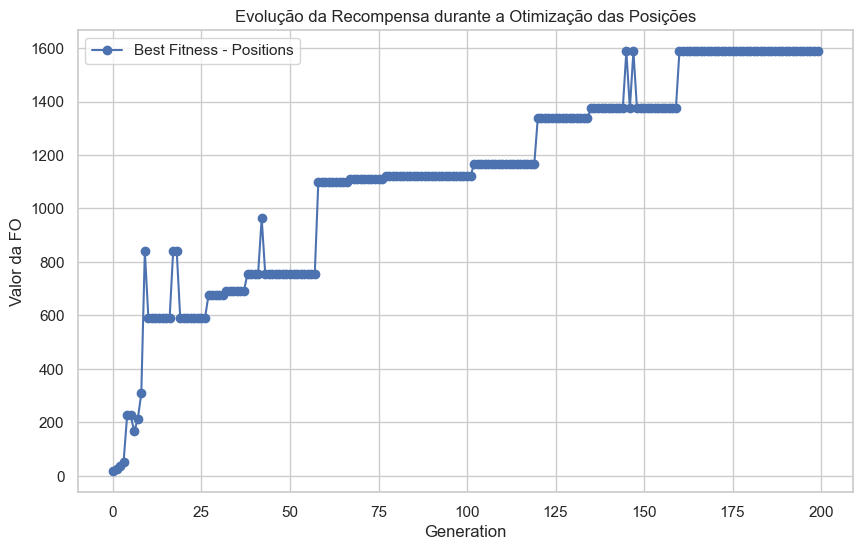

[75 20 70 25 70 20 75 25]
---------------------------Descobrir Direções------------------------------
Generation 0: Best Fitness = 1587.90
Generation 1: Best Fitness = 1587.90
Generation 2: Best Fitness = 1587.90
Generation 3: Best Fitness = 1587.90
Generation 4: Best Fitness = 1587.90
Generation 5: Best Fitness = 1587.90
Generation 6: Best Fitness = 1587.90
Generation 7: Best Fitness = 1587.90
Generation 8: Best Fitness = 1587.90
Generation 9: Best Fitness = 1587.90
Generation 10: Best Fitness = 1587.90
Generation 11: Best Fitness = 1587.90
Generation 12: Best Fitness = 1587.90
Generation 13: Best Fitness = 1587.90
Generation 14: Best Fitness = 1587.90
Generation 15: Best Fitness = 1587.90
Generation 16: Best Fitness = 1587.90
Generation 17: Best Fitness = 1587.90
Generation 18: Best Fitness = 1587.90
Generation 19: Best Fitness = 1587.90
Generation 20: Best Fitness = 1587.90
Generation 21: Best Fitness = 1587.90
Generation 22: Best Fitness = 1587.90
Generation 23: Best Fitness = 1587

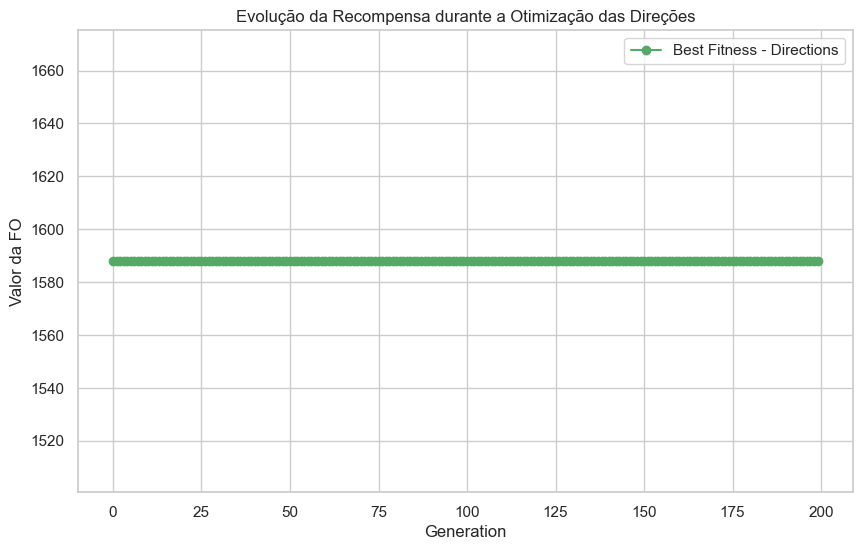

[124.33485118 127.55287262  89.56473827 168.1469345 ]


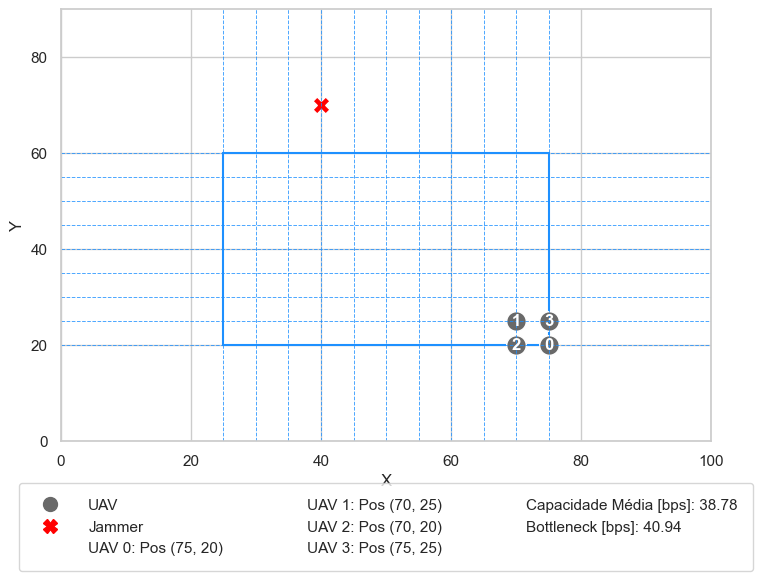


Recompensa: 1587.8958285381943

Capacidade Média: 38.784

Capacidade bottleneck mínima: 40.941973870194616

Capacidade bottleneck média: 46.16174717586691

Capacidade por Link: [20.471, 47.591, 45.491, 26.07, 47.591, 45.491, 52.14, 40.942, 22.746, 52.14, 40.942, 23.795]

Matriz de Capacidades: 	0.00 20.47 47.59 45.49
	26.07 0.00 47.59 45.49
	52.14 40.94 0.00 22.75
	52.14 40.94 23.80 0.00


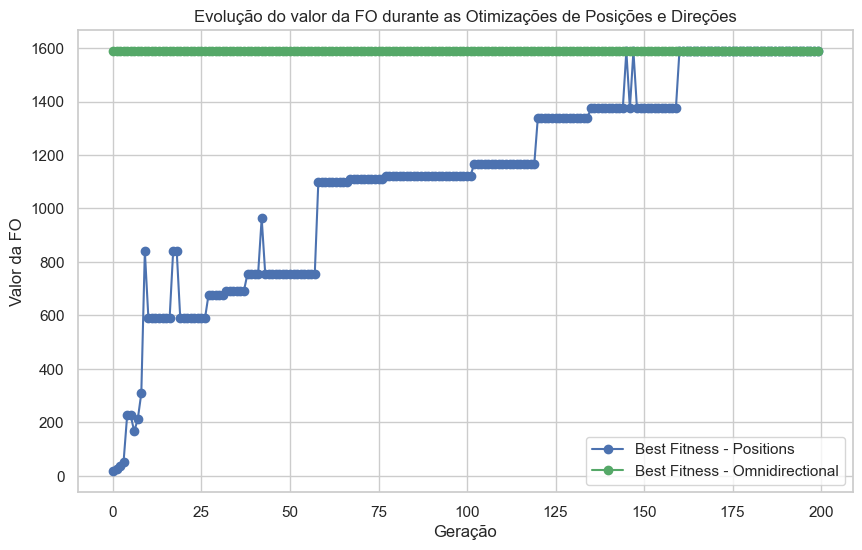

In [51]:
class GeneticAlgorithm:
    def __init__(self, env, grid_points, population_size=50, generations=200, mutation_rate=0.15, crossover_rate=0.9):
        self.env = env
        self.grid_points = grid_points
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

    def random_position_chromosome(self):
        indices = np.random.choice(len(self.grid_points), size=self.env.num_uavs, replace=False)
        return self.grid_points[indices].flatten()

    def random_direction_chromosome(self):
        return np.random.uniform(0, 360, size=self.env.num_uavs)

    def evaluate_position_fitness(self, chromosome):
        positions = chromosome.reshape(self.env.num_uavs, 2)
        self.env.posicoes = positions
        directions = np.zeros(self.env.num_uavs)  # Direções fixas ou predefinidas
        obs, reward, done, info = self.env.step(np.concatenate([directions, np.zeros(self.env.num_uavs), np.zeros(self.env.num_uavs)]))
        return reward, info

    def evaluate_direction_fitness(self, directions):
        self.env.direcoes_antena = directions
        obs, reward, done, info = self.env.step(np.concatenate([directions, np.zeros(self.env.num_uavs), np.zeros(self.env.num_uavs)]))
        return reward, info

    def select(self, population, fitness_scores):
        tournament_size = 5
        selected = []
        for _ in range(self.population_size):
            contenders = random.sample(list(enumerate(fitness_scores)), tournament_size)
            winner_index = max(contenders, key=lambda item: item[1][0])[0]
            selected.append(population[winner_index])
        return selected

    def crossover_positions(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            point = random.randint(1, len(parent1) - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return self.ensure_unique_positions(child1), self.ensure_unique_positions(child2)
        else:
            return parent1, parent2

    def crossover_directions(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            point = random.randint(1, len(parent1) - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1, parent2

    def mutate_positions(self, chromosome):
        positions = chromosome.reshape(self.env.num_uavs, 2)
        for i in range(self.env.num_uavs):
            if random.random() < self.mutation_rate:
                new_pos_index = np.random.choice(len(self.grid_points))
                while any(np.array_equal(self.grid_points[new_pos_index], positions[j]) for j in range(self.env.num_uavs)):
                    new_pos_index = np.random.choice(len(self.grid_points))
                positions[i] = self.grid_points[new_pos_index]
        return positions.flatten()

    def mutate_directions(self, directions):
        for i in range(len(directions)):
            if random.random() < self.mutation_rate:
                mutation = random.uniform(-90, 90)
                directions[i] = (directions[i] + mutation) % 360
        return directions

    def ensure_unique_positions(self, chromosome):
        positions = chromosome.reshape(self.env.num_uavs, 2)
        unique_positions = []
        for pos in positions:
            while any(np.array_equal(pos, upos) for upos in unique_positions):
                new_pos_index = np.random.choice(len(self.grid_points))
                pos = self.grid_points[new_pos_index]
            unique_positions.append(pos)
        return np.array(unique_positions).flatten()

    def run_position_optimization(self):
        best_fitness_ever = -np.inf
        best_positions_ever = None
        best_info_ever = None
        fitness_history_positions = []  # Para armazenar a evolução da recompensa

        population = [self.random_position_chromosome() for _ in range(self.population_size)]

        for generation in range(self.generations):
            fitness_scores = [self.evaluate_position_fitness(chrom) for chrom in population]
            best_fitness_in_gen, best_info_in_gen = max(fitness_scores, key=lambda x: x[0])
            fitness_history_positions.append(best_fitness_in_gen)  # Armazena a melhor recompensa de cada geração

            if best_fitness_in_gen > best_fitness_ever:
                best_fitness_ever = best_fitness_in_gen
                best_positions_ever = population[fitness_scores.index((best_fitness_in_gen, best_info_in_gen))]
                best_info_ever = best_info_in_gen

            selected = self.select(population, fitness_scores)
            new_population = []

            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(selected, 2)
                child1, child2 = self.crossover_positions(parent1, parent2)
                new_population.extend([self.mutate_positions(child1), self.mutate_positions(child2)])

            population = new_population[:self.population_size]
            print(f"Generation {generation}: Best Fitness = {best_fitness_in_gen:.2f}")

        # Plotar evolução da recompensa durante a otimização de posição
        plt.figure(figsize=(10, 6))
        plt.plot(fitness_history_positions, marker='o', linestyle='-', color='b', label='Best Fitness - Positions')
        plt.title('Evolução da Recompensa durante a Otimização das Posições')
        plt.xlabel('Generation')
        plt.ylabel('Valor da FO')
        plt.grid(True)
        plt.legend()
        plt.show()

        return best_positions_ever, best_info_ever, fitness_history_positions

    def run_direction_optimization(self, best_positions):
        best_fitness_ever = -np.inf
        best_directions_ever = None
        best_info_ever = None
        fitness_history_directions = []  # Para armazenar a evolução da recompensa

        population = [self.random_direction_chromosome() for _ in range(self.population_size)]

        for generation in range(self.generations):
            fitness_scores = [self.evaluate_direction_fitness(chrom) for chrom in population]
            best_fitness_in_gen, best_info_in_gen = max(fitness_scores, key=lambda x: x[0])
            fitness_history_directions.append(best_fitness_in_gen)  # Armazena a melhor recompensa de cada geração

            if best_fitness_in_gen > best_fitness_ever:
                best_fitness_ever = best_fitness_in_gen
                best_directions_ever = population[fitness_scores.index((best_fitness_in_gen, best_info_in_gen))]
                best_info_ever = best_info_in_gen

            selected = self.select(population, fitness_scores)
            new_population = []

            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(selected, 2)
                child1, child2 = self.crossover_directions(parent1, parent2)
                new_population.extend([self.mutate_directions(child1), self.mutate_directions(child2)])

            population = new_population[:self.population_size]
            print(f"Generation {generation}: Best Fitness = {best_fitness_in_gen:.2f}")

        # Plotar evolução da recompensa durante a otimização de direção
        plt.figure(figsize=(10, 6))
        plt.plot(fitness_history_directions, marker='o', linestyle='-', color='g', label='Best Fitness - Directions')
        plt.title('Evolução da Recompensa durante a Otimização das Direções')
        plt.xlabel('Generation')
        plt.ylabel('Valor da FO')
        plt.grid(True)
        plt.legend()
        plt.show()

        return best_directions_ever, best_info_ever, fitness_history_directions

# Exemplo de uso do algoritmo dividido em duas fases
env = UAVCommunicationEnv()
env.subgrade_start=[25,20]
env.posicao_jammer=[40,70]
# Criar uma instância do Algoritmo Genético
ga = GeneticAlgorithm(env, grid_points)

# env.posicao_jammer=[45,35]

# Fase 1: Otimização das Posições
print('---------------------------Descobrir Posições------------------------------')
best_positions, _, fitness_history_positions = ga.run_position_optimization()

print(best_positions)


# best_positions=np.array([
#     [35, 50],  # Posição do Drone 1
#     [40, 30],  # Posição do Drone 2
#     [55, 25],  # Posição do Drone 3
#     [70, 50]   # Posição do Drone 4
# ])

# Atualizar as melhores posições no ambiente
env.posicoes = best_positions.reshape(env.num_uavs, 2)

# Fase 2: Otimização das Direções
print('---------------------------Descobrir Direções------------------------------')
best_directions, best_info, fitness_history_directions = ga.run_direction_optimization(best_positions)
print(best_directions)

# best_directions=np.array([293,41,167,168])

# Atualizar as melhores direções no ambiente
env.direcoes_antena = best_directions

# Renderizar a melhor solução encontrada
title = ''
bottleneck = best_info['Capacidade bottleneck mínima']
cap_media = best_info['Capacidade média [Kbps]']
env.render()

# Imprimir detalhes da melhor solução encontrada
print("\nRecompensa:", best_info['Recompensa'])
print("\nCapacidade Média:", best_info['Capacidade média [Kbps]']) 
print("\nCapacidade bottleneck mínima:", best_info['Capacidade bottleneck mínima'])  
print("\nCapacidade bottleneck média:", best_info['Capacidade bottleneck média'])
print("\nCapacidade por Link:", best_info['Capacidades_por_link [Kbps]'])
print("\nMatriz de Capacidades:", '\n'.join(['\t' + ' '.join(f"{item:.2f}" for item in row) for row in best_info['Matriz de Capacidades [Kbps]']]))
capacidade_matriz = best_info['Matriz de Capacidades [Kbps]']


# Plotar gráfico combinado
plt.figure(figsize=(10, 6))
plt.plot(fitness_history_positions, marker='o', linestyle='-', color='b', label='Best Fitness - Positions')
plt.plot(fitness_history_directions, marker='o', linestyle='-', color='g', label='Best Fitness - Omnidirectional')
plt.title('Evolução do valor da FO durante as Otimizações de Posições e Direções')
plt.xlabel('Geração')
plt.ylabel('Valor da FO')
plt.grid(True)
plt.legend()
plt.show()